<a href="https://colab.research.google.com/github/mechanic3000/GB_PyTorch_course/blob/Lesson_08/Lesson_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch
from torch.nn import functional as F
from tqdm import trange

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [86]:
x = torch.linspace(-30, 30, steps=100000)
x[x == 0] = 0.0001
train = torch.sin(x) / x - x / 10

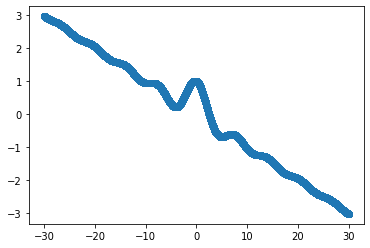

In [87]:
plt.scatter(x, train)

In [88]:
r1 = -10
r2 = 10

x1 = (r1 - r2) * torch.rand(3000) + r2
x1[x1 == 0] = 0.0001

valid = torch.sin(x1) / x1 - x1 / 10

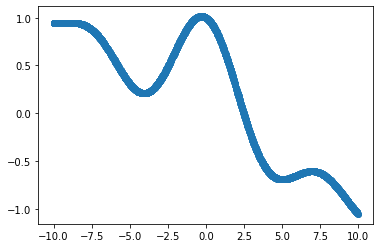

In [89]:
plt.scatter(x1, valid)

In [90]:
x = (x - x.mean()) / x.std()

train_ds = torch.utils.data.TensorDataset(x.view(-1, 1), train.view(-1, 1))
valid_ds = torch.utils.data.TensorDataset(x1.view(-1, 1), valid.view(-1, 1))

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)

In [91]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.approx = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.02),
            nn.Linear(32, 128),
            nn.LeakyReLU(0.02),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.02),
            nn.Linear(32, 1, bias=False)
        )
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.kaiming_uniform_(p)

    def forward(self, x):
        x = self.approx(x)

        return x


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 16)
        self.fc = nn.Linear(16, 1)

        # for p in self.parameters():
        #     if p.dim() > 1:
        #         nn.init.normal_(p, 0, 0.02)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc(x)

        return x

In [92]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [93]:
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002)

In [94]:
train_d_losses, train_g_losses = [], []

for i in trange(300):
    
    train_de_losses, train_ge_losses = [], []
    for i, batch in enumerate(train_dl):
        x, y = batch
        x, y = x.to(device), y.to(device)

        noise = torch.randn(x.size(0), 1).to(device)
        gen = generator(noise)

        generator.train()
        optimizer_gen.zero_grad()

        fake_pred = discriminator(gen)
        # loss_g = 0.9 * F.mse_loss(gen, y) + 0.1 * F.binary_cross_entropy_with_logits(fake_pred, torch.ones_like(fake_pred))
        loss_g = F.binary_cross_entropy_with_logits(fake_pred, torch.ones_like(fake_pred))

        loss_g.backward()
        optimizer_gen.step()
        train_ge_losses.append(loss_g.item())

        discriminator.train()
        optimizer_disc.zero_grad()

        fake_pred = discriminator(gen.detach())
        true_pred = discriminator(y)

        loss_d = F.binary_cross_entropy_with_logits(true_pred, torch.ones_like(true_pred)) + F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred))
        loss_d = loss_d * 0.5

        loss_d.backward()
        optimizer_disc.step()
        train_de_losses.append(loss_d.item())
    
    train_g_losses.append(np.mean(train_ge_losses))
    train_d_losses.append(np.mean(train_de_losses))


100%|██████████| 300/300 [11:17<00:00,  2.26s/it]


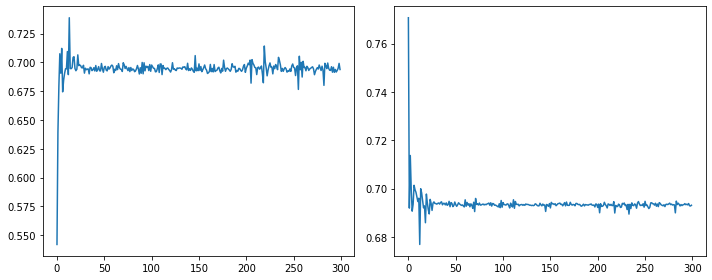

In [95]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(train_g_losses)
plt.subplot(122)
plt.plot(train_d_losses)
plt.tight_layout()
plt.show()

In [104]:
generator.eval()


r1 = -20
r2 = 20

noise = (r1 - r2) * torch.rand(3000, 1).to(device) + r2

out = generator(noise)

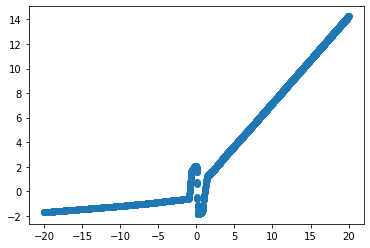

In [105]:
plt.scatter(noise.squeeze().cpu().numpy(), out.squeeze().detach().cpu().numpy())